# Setup

In [1]:
import json
from sae_lens import SAE, HookedSAETransformer
from functools import partial
import einops
import os
import gc
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from datasets import load_dataset
from transformers import AutoTokenizer
from transformer_lens.hook_points import (
    HookPoint,
) 
import numpy as np
import pandas as pd
from pprint import pprint as pp
from typing import Tuple
from torch import Tensor
from functools import lru_cache
from typing import TypedDict, Optional, Tuple, Union
from tqdm import tqdm
import random

In [2]:
with open("config.json", 'r') as file:
   config = json.load(file)
token = config.get('huggingface_token', None)
os.environ["HF_TOKEN"] = token

# Define device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

hf_cache = "/work/pi_jensen_umass_edu/jnainani_umass_edu/mechinterp/huggingface_cache/hub"
os.environ["HF_HOME"] = hf_cache

# Load the model
model = HookedSAETransformer.from_pretrained("google/gemma-2-9b", device=device, cache_dir=hf_cache) 

pad_token_id = model.tokenizer.pad_token_id
for param in model.parameters():
   param.requires_grad_(False)

Device: cuda


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2-9b into HookedTransformer


In [3]:
device = "cuda"
layers= [7, 14, 21, 40]
l0s = [92, 67, 129, 125]
saes = [SAE.from_pretrained(release="gemma-scope-9b-pt-res", sae_id=f"layer_{layers[i]}/width_16k/average_l0_{l0s[i]}", device=device)[0] for i in range(len(layers))]

# utils trial

# Helper functions and classes 

In [4]:
def cleanup_cuda():
   torch.cuda.empty_cache()
   gc.collect()

def clear_memory():
    for sae in saes:
        for param in sae.parameters():
            param.grad = None
        for param in sae.mask.parameters():
            param.grad = None
    for param in model.parameters():
        param.grad = None
    cleanup_cuda()

class SAEMasks(nn.Module):
    def __init__(self, hook_points, masks):
        super().__init__()
        self.hook_points = hook_points  # list of strings
        self.masks = masks

    def forward(self, x, sae_hook_point, mean_ablation=None):
        index = self.hook_points.index(sae_hook_point)
        mask = self.masks[index]
        censored_activations = torch.ones_like(x)
        if mean_ablation is not None:
            censored_activations = censored_activations * mean_ablation
        else:
            censored_activations = censored_activations * 0
        
        diff_to_x = x - censored_activations
        return censored_activations + diff_to_x * mask

    def print_mask_statistics(self):
        """
        Prints statistics about each binary mask:
          - total number of elements (latents)
          - total number of 'on' latents (mask == 1)
          - average on-latents per token
            * If shape == [latent_dim], there's effectively 1 token
            * If shape == [seq, latent_dim], it's 'sum of on-latents / seq'
        """
        for i, mask in enumerate(self.masks):
            shape = list(mask.shape)
            total_latents = mask.numel()
            total_on = mask.sum().item()  # number of 1's in the mask

            # Average on-latents per token depends on dimensions
            if len(shape) == 1:
                # e.g., shape == [latent_dim]
                avg_on_per_token = total_on  # only one token
            elif len(shape) == 2:
                # e.g., shape == [seq, latent_dim]
                seq_len = shape[0]
                avg_on_per_token = total_on / seq_len if seq_len > 0 else 0
            else:
                # If there's more than 2 dims, adapt as needed;
                # we'll just define "token" as the first dimension.
                seq_len = shape[0]
                avg_on_per_token = total_on / seq_len if seq_len > 0 else 0

            print(f"Statistics for mask '{self.hook_points[i]}':")
            print(f"  - Shape: {shape}")
            print(f"  - Total latents: {total_latents}")
            print(f"  - Latents ON (mask=1): {int(total_on)}")
            print(f"  - Average ON per token: {avg_on_per_token:.4f}\n")

    def save(self, save_dir, file_name="sae_masks.pt"):
        """
        Saves hook_points and masks to a single file (file_name) within save_dir.
        If you want multiple mask sets in the same directory, call save() with
        different file_name values. The directory is created if it does not exist.
        """
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        save_path = os.path.join(save_dir, file_name)
        checkpoint = {
            "hook_points": self.hook_points,
            "masks": self.masks
        }
        torch.save(checkpoint, save_path)
        print(f"SAEMasks saved to {save_path}")

    @classmethod
    def load(cls, load_dir, file_name="sae_masks.pt"):
        """
        Loads hook_points and masks from a single file (file_name) within load_dir,
        returning an instance of SAEMasks. If you stored multiple mask sets in the
        directory, specify the file_name to load the correct one.
        """
        load_path = os.path.join(load_dir, file_name)
        if not os.path.isfile(load_path):
            raise FileNotFoundError(f"No saved SAEMasks found at {load_path}")

        checkpoint = torch.load(load_path)
        hook_points = checkpoint["hook_points"]
        masks = checkpoint["masks"]

        instance = cls(hook_points=hook_points, masks=masks)
        print(f"SAEMasks loaded from {load_path}")
        return instance
    def get_num_latents(self):
        num_latents = 0
        for mask in self.masks:
            num_latents += (mask>0).sum().item()
        return num_latents

class SparseMask(nn.Module):
    def __init__(self, shape, l1, seq_len=None, distinct_l1=0):
        super().__init__()
        if seq_len is not None:
            self.mask = nn.Parameter(torch.ones(seq_len, shape))
        else:
            self.mask = nn.Parameter(torch.ones(shape))
        self.l1 = l1
        self.distinct_l1 = distinct_l1
        self.max_temp = torch.tensor(1000.0)
        self.sparsity_loss = None
        self.ratio_trained = 1
        self.temperature = 1
        self.distinct_sparsity_loss = 0


    def forward(self, x, binary=False, mean_ablation=None):
        if binary:
            # binary mask, 0 if negative, 1 if positive
            binarized = (self.mask > 0).float()
            if mean_ablation is None:
                return x * binarized
            else:
                diff = x - mean_ablation
                return diff * binarized + mean_ablation
            

        self.temperature = self.max_temp ** self.ratio_trained
        mask = torch.sigmoid(self.mask * self.temperature)
        # mask = self.mask
        self.sparsity_loss = torch.abs(mask).sum() * self.l1
        # print("hello", torch.abs(mask).sum()) 
        # if len(mask.shape) == 2:
        #     self.distinct_sparsity_loss = torch.abs(mask).max(dim=0).values.sum() * self.distinct_l1

        if mean_ablation is None:
            return x * mask
        else:
            diff = x - mean_ablation
            return diff * mask + mean_ablation

class IGMask(nn.Module):
    # igscores is seq x num_sae_latents
    def __init__(self, ig_scores):
        super().__init__()
        self.ig_scores = ig_scores

    def forward(self, x, threshold, mean_ablation = None):
        censored_activations = torch.ones_like(x)
        if mean_ablation != None:
            censored_activations = censored_activations * mean_ablation
        else:
            censored_activations = censored_activations * 0

        mask = (self.ig_scores.abs() > threshold).float()
        
        diff_to_x = x - censored_activations
        return censored_activations + diff_to_x * mask
    
    def get_threshold_info(self, threshold):
        mask = (self.ig_scores.abs() > threshold).float()

        total_latents = mask.sum()
        avg_latents_per_tok = mask.sum()/mask.shape[0]
        latents_per_tok = mask.sum(dim=-1)
        return {"total_latents":total_latents,
                "avg_latents_per_tok":avg_latents_per_tok,
                "latents_per_tok":latents_per_tok}
    
    def get_binarized_mask(self, threshold):
        return (self.ig_scores.abs()>threshold).float()
    
def refresh_class():
    for sae in saes:
        if hasattr(sae, 'igmask'):
            sae.igmask = IGMask(sae.igmask.ig_scores)

try:
    refresh_class()
except Exception as e:
    print(e)

refresh_class()

def produce_ig_binary_masks(threshold=0.01):
    hook_points = []
    masks = []

    for sae in saes:
        hook_point = sae.cfg.hook_name
        mask = sae.igmask.get_binarized_mask(threshold=threshold)
        hook_points.append(hook_point)
        masks.append(mask)
    
    return SAEMasks(
        hook_points=hook_points,
        masks=masks
    )

In [5]:
bos_token_id = model.tokenizer.bos_token_id

def build_sae_hook_fn(
    # Core components
    sae,
    sequence,
    
    # Masking options
    circuit_mask: Optional[SAEMasks] = None,
    use_mask=False,
    binarize_mask=False,
    mean_mask=False,
    ig_mask_threshold=None,
    
    # Caching behavior
    cache_sae_grads=False,
    cache_masked_activations=False,
    cache_sae_activations=False,
    
    # Ablation options
    mean_ablate=False,  # Controls mean ablation of the SAE
    fake_activations=False,  # Controls whether to use fake activations
    ):    # make the mask for the sequence
    mask = torch.ones_like(sequence, dtype=torch.bool)
    # mask[sequence == pad_token_id] = False
    mask[sequence == bos_token_id] = False # where mask is false, keep original
    def sae_hook(value, hook):
        # print(f"sae {sae.cfg.hook_name} running at layer {hook.layer()}")
        feature_acts = sae.encode(value)
        feature_acts = feature_acts * mask.unsqueeze(-1)
        if fake_activations != False and sae.cfg.hook_layer == fake_activations[0]:
            feature_acts = fake_activations[1]
        if cache_sae_grads:
            raise NotImplementedError("torch is confusing")
            sae.feature_acts = feature_acts.requires_grad_(True)
            sae.feature_acts.retain_grad()
        
        if cache_sae_activations:
            sae.feature_acts = feature_acts.detach().clone()
        
        # Learned Binary Masking
        if use_mask:
            if mean_mask:
                # apply the mask, with mean ablations
                feature_acts = sae.mask(feature_acts, binary=binarize_mask, mean_ablation=sae.mean_ablation)
            else:
                # apply the mask, without mean ablations
                feature_acts = sae.mask(feature_acts, binary=binarize_mask)

        # IG Masking
        if ig_mask_threshold != None:
            # apply the ig mask
            if mean_mask:
                feature_acts = sae.igmask(feature_acts, threshold=ig_mask_threshold, mean_ablation=sae.mean_ablation)
            else:
                feature_acts = sae.igmask(feature_acts, threshold=ig_mask_threshold)
      
        if circuit_mask is not None:
            hook_point = sae.cfg.hook_name
            if mean_mask==True:
                feature_acts = circuit_mask(feature_acts, hook_point, mean_ablation=sae.mean_ablation)
            else:
                feature_acts = circuit_mask(feature_acts, hook_point)
            
        if cache_masked_activations:
            sae.feature_acts = feature_acts.detach().clone()
        if mean_ablate:
            feature_acts = sae.mean_ablation

        out = sae.decode(feature_acts)
        # choose out or value based on the mask
        mask_expanded = mask.unsqueeze(-1).expand_as(value)
        value = torch.where(mask_expanded, out, value)
        return value
    return sae_hook

def build_hooks_list(sequence,
                    cache_sae_activations=False,
                    cache_sae_grads=False,
                    circuit_mask=None,
                    use_mask=False,
                    binarize_mask=False,
                    mean_mask=False,
                    cache_masked_activations=False,
                    mean_ablate=False,
                    fake_activations: Tuple[int, torch.Tensor] = False,
                    ig_mask_threshold=None,
                    ):
    hooks = []
    for sae in saes:
        hooks.append(
            (
            sae.cfg.hook_name,
            build_sae_hook_fn(sae, sequence, cache_sae_grads=cache_sae_grads, circuit_mask=circuit_mask, use_mask=use_mask, binarize_mask=binarize_mask, cache_masked_activations=cache_masked_activations, cache_sae_activations=cache_sae_activations, mean_mask=mean_mask, mean_ablate=mean_ablate, fake_activations=fake_activations, ig_mask_threshold=ig_mask_threshold),
            )
        )
    return hooks 

def build_sae_logitfn(**kwargs):
    def logitfn(tokens):
        return model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, **kwargs)
            )
    return logitfn

# Data

In [16]:
# import json
# N = 5
# K = 1
# file_path = f'data/codereason/index/data_len{N}_digit{K}_errOnly_output.json'
# with open(file_path, 'r') as file:
#     data = json.load(file)
# example_length = 24

In [4]:
import json
file_path = 'data/sva/rc_train.json'
with open(file_path, 'r') as file:
    data = [json.loads(line) for line in file]
for entry in data:
    print(entry)
    break
example_length = 7

{'clean_prefix': 'The friends that the dancer visits', 'patch_prefix': 'The friend that the dancer visits', 'clean_answer': ' go', 'patch_answer': ' goes', 'case': 'plural_singular'}


In [7]:
import json
N = 6
K = 1
file_path = f'data/codereason/index/data_len{N}_digit{K}.json'
with open(file_path, 'r') as file:
    data = json.load(file)
data[0]
example_length = 29 # 41

In [9]:
import json
file_path = f'data/ioi/ioi_train_21.json'
with open(file_path, 'r') as file:
    data = json.load(file)
data[0]
example_length = 20 # 41

In [5]:
data[1]

{'clean_prefix': 'The athlete that the chefs hate',
 'patch_prefix': 'The athletes that the chefs hate',
 'clean_answer': ' is',
 'patch_answer': ' are',
 'case': 'singular_plural'}

In [6]:
len(model.tokenizer(data[0]['clean_prefix']).input_ids)

7

In [7]:
clean_data = []
corr_data = []
clean_labels = []
corr_labels = []
for entry in data:
    clean_len = len(model.tokenizer(entry['clean_prefix']).input_ids)
    corr_len = len(model.tokenizer(entry['patch_prefix']).input_ids)
    if clean_len == corr_len == example_length:
        clean_data.append(entry['clean_prefix'])
        corr_data.append(entry['patch_prefix'])
        clean_labels.append(entry['clean_answer'])
        corr_labels.append(entry['patch_answer'])
print(len(clean_data))

N = 3000
clean_tokens = model.to_tokens(clean_data[:N])
corr_tokens = model.to_tokens(corr_data[:N])
clean_label_tokens = model.to_tokens(clean_labels[:N], prepend_bos=False).squeeze(-1)
corr_label_tokens = model.to_tokens(corr_labels[:N], prepend_bos=False).squeeze(-1)
print(clean_tokens.shape, corr_tokens.shape)

def logit_diff_fn(logits, clean_labels, corr_labels, token_wise=False):
    clean_logits = logits[torch.arange(logits.shape[0]), -1, clean_labels]
    corr_logits = logits[torch.arange(logits.shape[0]), -1, corr_labels]
    return (clean_logits - corr_logits).mean() if not token_wise else (clean_logits - corr_logits)

batch_size = 16 
clean_tokens = clean_tokens[:batch_size*(len(clean_tokens)//batch_size)]
corr_tokens = corr_tokens[:batch_size*(len(corr_tokens)//batch_size)]
clean_label_tokens = clean_label_tokens[:batch_size*(len(clean_label_tokens)//batch_size)]
corr_label_tokens = corr_label_tokens[:batch_size*(len(corr_label_tokens)//batch_size)]

clean_tokens = clean_tokens.reshape(-1, batch_size, clean_tokens.shape[-1])
corr_tokens = corr_tokens.reshape(-1, batch_size, corr_tokens.shape[-1])
clean_label_tokens = clean_label_tokens.reshape(-1, batch_size)
corr_label_tokens = corr_label_tokens.reshape(-1, batch_size)

print(clean_tokens.shape, corr_tokens.shape, clean_label_tokens.shape, corr_label_tokens.shape)


100731
torch.Size([3000, 7]) torch.Size([3000, 7])
torch.Size([187, 16, 7]) torch.Size([187, 16, 7]) torch.Size([187, 16]) torch.Size([187, 16])


In [9]:
from helpers.utils import cleanup_cuda

In [10]:
use_mask = False 
mean_mask = False
avg_logit_diff = 0
cleanup_cuda()
with torch.no_grad():
    for i in range(10):
        logits = model(
            clean_tokens[i]
            )
        ld = logit_diff_fn(logits, clean_label_tokens[i], corr_label_tokens[i])
        print(ld)
        avg_logit_diff += ld
        del logits
        cleanup_cuda()
model.reset_hooks(including_permanent=True)
model.reset_saes()
avg_model_diff = (avg_logit_diff / 10).item()
print("Average LD: ", avg_model_diff)

tensor(3.1996, device='cuda:0')
tensor(3.8848, device='cuda:0')
tensor(4.2279, device='cuda:0')
tensor(3.7378, device='cuda:0')
tensor(3.6833, device='cuda:0')
tensor(4.1826, device='cuda:0')
tensor(3.8361, device='cuda:0')
tensor(3.6719, device='cuda:0')
tensor(4.0104, device='cuda:0')
tensor(4.4744, device='cuda:0')
Average LD:  3.8908863067626953


In [20]:
from helpers.utils import run_sae_hook_fn

In [13]:
logits, saes = run_sae_hook_fn(model, saes, clean_tokens[0])
ld = logit_diff_fn(logits, clean_label_tokens[0], corr_label_tokens[0])
print(ld)
del logits 
cleanup_cuda()

tensor(2.7792, device='cuda:0', grad_fn=<MeanBackward0>)


In [14]:
use_mask = False 
mean_mask = False
avg_logit_diff = 0
cleanup_cuda()
with torch.no_grad():
    for i in range(10):
        # logits = model.run_with_hooks(
        #     clean_tokens[i], 
        #     return_type="logits", 
        #     fwd_hooks=build_hooks_list(clean_tokens[i], use_mask=use_mask, mean_mask=mean_mask)
        #     )
        logits, saes = run_sae_hook_fn(model, saes, clean_tokens[i])
        ld = logit_diff_fn(logits, clean_label_tokens[i], corr_label_tokens[i])
        print(ld)
        avg_logit_diff += ld
        del logits
        cleanup_cuda()
model.reset_hooks(including_permanent=True)
model.reset_saes()
avg_logit_diff = (avg_logit_diff / 10).item()
print("Average LD: ", avg_logit_diff)

tensor(2.7792, device='cuda:0')
tensor(3.6336, device='cuda:0')
tensor(3.7514, device='cuda:0')
tensor(3.3448, device='cuda:0')
tensor(3.6474, device='cuda:0')
tensor(4.0851, device='cuda:0')
tensor(3.2005, device='cuda:0')
tensor(3.2937, device='cuda:0')
tensor(3.4509, device='cuda:0')
tensor(3.9535, device='cuda:0')
Average LD:  3.5140016078948975


In [15]:
avg_logit_diff / avg_model_diff

0.9031365428969899

In [16]:
for sae in saes:
    sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length).to(device)

def running_mean_tensor(old_mean, new_value, n):
    return old_mean + (new_value - old_mean) / n

def get_sae_means(mean_tokens, total_batches, batch_size, per_token_mask=False):
    for sae in saes:
        sae.mean_ablation = torch.zeros(sae.cfg.d_sae).float().to(device)
    
    with tqdm(total=total_batches*batch_size, desc="Mean Accum Progress") as pbar:
        for i in range(total_batches):
            for j in range(batch_size):
                with torch.no_grad():
                    _ = model.run_with_hooks(
                        mean_tokens[i, j], 
                        return_type="logits", 
                        fwd_hooks=build_hooks_list(mean_tokens[i, j], cache_sae_activations=True)
                        )
                    for sae in saes:
                        sae.mean_ablation = running_mean_tensor(sae.mean_ablation, sae.feature_acts, i+1)
                    cleanup_cuda()
                pbar.update(1)

            if i >= total_batches:
                break

get_sae_means(corr_tokens, 40, 16)

Mean Accum Progress:   0%|          | 0/640 [00:00<?, ?it/s]

Mean Accum Progress: 100%|██████████| 640/640 [02:37<00:00,  4.07it/s]


In [17]:
avg_mean_diff = 0
with torch.no_grad():
    for i in range(3):
        logits = model.run_with_hooks(
            clean_tokens[i], 
            return_type="logits", 
            fwd_hooks=build_hooks_list(clean_tokens[i], mean_ablate=True)
            )
        ld = logit_diff_fn(logits, clean_label_tokens[i], corr_label_tokens[i])
        print(ld)
        avg_mean_diff += ld
        del logits
        cleanup_cuda()
print("Average LD: ", avg_mean_diff)

tensor(0.1004, device='cuda:0')
tensor(-0.1340, device='cuda:0')
tensor(-0.1819, device='cuda:0')
Average LD:  tensor(-0.2155, device='cuda:0')


# error node mean 

In [24]:
from helpers.utils import run_sae_hook_fn

In [28]:
import helpers.utils
from importlib import reload

reload(helpers.utils)  # Forces the module to reload
run_sae_hook_fn = helpers.utils.run_sae_hook_fn

In IPython
Set autoreload


In [29]:
logits, saes = run_sae_hook_fn(model, saes, clean_tokens[0], calc_error=True, use_error=True)
ld = logit_diff_fn(logits, clean_label_tokens[0], corr_label_tokens[0])
print(ld)
del logits
cleanup_cuda()


tensor(3.1996, device='cuda:0', grad_fn=<MeanBackward0>)


In [31]:
for sae in saes:
    print(sae.error_term.shape)

torch.Size([16, 7, 3584])
torch.Size([16, 7, 3584])
torch.Size([16, 7, 3584])
torch.Size([16, 7, 3584])


In [40]:
import helpers.utils
from importlib import reload

reload(helpers.utils)  # Forces the module to reload
run_sae_hook_fn = helpers.utils.run_sae_hook_fn
SparseMask = helpers.utils.SparseMask

`get_ipython` not available. This script is not running in IPython.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
In IPython
Set autoreload


In [35]:
saes[0].cfg

SAEConfig(architecture='jumprelu', d_in=3584, d_sae=16384, activation_fn_str='relu', apply_b_dec_to_input=False, finetuning_scaling_factor=False, context_size=1024, model_name='gemma-2-9b', hook_name='blocks.7.hook_resid_post', hook_layer=7, hook_head_index=None, prepend_bos=True, dataset_path='monology/pile-uncopyrighted', dataset_trust_remote_code=True, normalize_activations=None, dtype='float32', device='cuda', sae_lens_training_version=None, activation_fn_kwargs={}, neuronpedia_id=None, model_from_pretrained_kwargs={}, seqpos_slice=(None,))

In [41]:
for sae in saes:
    sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length).to(device)

def running_mean_tensor(old_mean, new_value, n):
    return old_mean + (new_value - old_mean) / n

def get_sae_error_means(mean_tokens, total_batches, batch_size, per_token_mask=False):
    for sae in saes:
        sae.mean_error = torch.zeros(sae.cfg.d_in).float().to(device)
    
    with tqdm(total=total_batches*batch_size, desc="Mean Accum Progress") as pbar:
        for i in range(total_batches):
            for j in range(batch_size):
                with torch.no_grad():
                    _ = run_sae_hook_fn(model, saes, mean_tokens[i, j], calc_error=True)
                    
                    #model.run_with_hooks(
                        # mean_tokens[i, j], 
                        # return_type="logits", 
                        # fwd_hooks=build_hooks_list(mean_tokens[i, j], cache_sae_activations=True)
                        # )
                    for sae in saes:
                        sae.mean_error = running_mean_tensor(sae.mean_error, sae.error_term, i+1)
                    cleanup_cuda()
                pbar.update(1)

            if i >= total_batches:
                break

get_sae_error_means(corr_tokens, 5, 16)

Mean Accum Progress:   1%|▏         | 1/80 [00:00<00:24,  3.21it/s]

Mean Accum Progress: 100%|██████████| 80/80 [00:21<00:00,  3.68it/s]


In [42]:
saes[0].mean_error

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.4405, -0.4864,  0.2088,  ...,  0.4699, -0.3904,  0.0812],
         [ 0.5213, -0.6703, -0.8598,  ...,  0.3009,  0.5313,  0.6805],
         ...,
         [-0.3385, -0.7575, -0.1364,  ...,  0.0169,  0.3107, -0.9056],
         [ 0.0170, -0.3084, -0.5777,  ...,  0.0857,  0.3822,  0.2479],
         [ 0.2825, -0.4872, -1.2073,  ...,  0.9614,  0.1928,  0.5701]]],
       device='cuda:0')

In [43]:
logits, saes = run_sae_hook_fn(model, saes, clean_tokens[0], use_mean_error=True)
ld = logit_diff_fn(logits, clean_label_tokens[0], corr_label_tokens[0])
print(ld)
del logits
cleanup_cuda()

tensor(2.8793, device='cuda:0', grad_fn=<MeanBackward0>)


# Binary Mask Optimization

In [18]:
import torch.nn.functional as F
import wandb
import signal
class KeyboardInterruptBlocker:
    def __enter__(self):
        # Block SIGINT and store old mask
        self.old_mask = signal.pthread_sigmask(signal.SIG_BLOCK, {signal.SIGINT})

    def __exit__(self, exc_type, exc_value, traceback):
        # Restore old mask (unblock SIGINT)
        signal.pthread_sigmask(signal.SIG_SETMASK, self.old_mask)

class Range:
    def __init__(self, *args):
        # Support for range(start, stop, step) or range(stop)
        self.args = args

        # Validate input like the built-in range does
        if len(self.args) not in {1, 2, 3}:
            raise TypeError(f"Range expected at most 3 arguments, got {len(self.args)}")
        
        self.range = __builtins__.range(*self.args)  # Create the range object

    def __iter__(self):
        for i in self.range:
            try:
                with KeyboardInterruptBlocker():
                    yield i
            except KeyboardInterrupt:
                print("Keyboard interrupt received. Exiting iteration.")
                break

    def __len__(self):
        return len(self.range)

def do_training_run(token_dataset, labels_dataset, corr_labels_dataset, sparsity_multiplier, task, example_length=6, loss_function='ce', per_token_mask=False, use_mask=True, mean_mask=False, portion_of_data = 0.5, distinct_sparsity_multiplier=0 ):

    def logitfn(tokens, use_mask, mean_mask):
        logits =  model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, use_mask=use_mask, mean_mask=mean_mask)
            )
        return logits

    def forward_pass(batch, clean_label_tokens, corr_label_tokens, logitfn, ratio_trained=1, loss_function='ce'):
        for sae in saes:
            sae.mask.ratio_trained = ratio_trained
        tokens = batch
        logits = logitfn(tokens, use_mask, mean_mask)
        model_logits = logitfn(tokens, False, False)
        last_token_logits = logits[:, -1, :]
        if loss_function == 'ce':
            loss = F.cross_entropy(last_token_logits, clean_label_tokens)
        elif loss_function == 'logit_diff':
            fwd_logit_diff = logit_diff_fn(logits, clean_label_tokens, corr_label_tokens)
            model_logit_diff = logit_diff_fn(model_logits, clean_label_tokens, corr_label_tokens)
            loss = torch.abs(model_logit_diff - fwd_logit_diff)
        
        del model_logits, logits
        cleanup_cuda()

        sparsity_loss = 0
        distinct_sparsity_loss = 0
        # if per_token_mask:
        #     distinct_sparsity_loss = 0
        for sae in saes:
            sparsity_loss = sparsity_loss + sae.mask.sparsity_loss
            # if per_token_mask:
            #     distinct_sparsity_loss = distinct_sparsity_loss + sae.mask.distinct_sparsity_loss
        
        sparsity_loss = sparsity_loss / len(saes)
        distinct_sparsity_loss = distinct_sparsity_loss / len(saes)

        return loss, sparsity_loss, distinct_sparsity_loss

    print("doing a run with sparsity multiplier", sparsity_multiplier)
    all_optimized_params = []
    config = {
        "batch_size": 16,
        "learning_rate": 1,
        "total_steps": token_dataset.shape[0]*portion_of_data,
        "sparsity_multiplier": sparsity_multiplier
    }

    for sae in saes:
        if per_token_mask:
            sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length).to(device)
        else:
            sae.mask = SparseMask(sae.cfg.d_sae, 1.0).to(device)
        all_optimized_params.extend(list(sae.mask.parameters()))
        sae.mask.max_temp = torch.tensor(200.0)
    
    wandb.init(project="sae circuits", config=config)
    optimizer = optim.Adam(all_optimized_params, lr=config["learning_rate"])
    total_steps = config["total_steps"] #*20 #*config["batch_size"]
    # epochs = 20
    with tqdm(total=total_steps*1.1, desc="Training Progress") as pbar:
        # for epoch in range(epochs):
        for i, (x, y, z) in enumerate(zip(token_dataset, labels_dataset, corr_labels_dataset)):
            with KeyboardInterruptBlocker():
                optimizer.zero_grad()
                
                # Calculate ratio trained
                ratio_trained =  i / total_steps*1.1
                
                # Update mask ratio for each SAE
                for sae in saes:
                    sae.mask.ratio_trained = ratio_trained
                
                # Forward pass with updated ratio_trained
                loss, sparsity_loss, _ = forward_pass(x, y, z, logitfn, ratio_trained=ratio_trained, loss_function=loss_function)
                # if per_token_mask:
                #     sparsity_loss = sparsity_loss / example_length
                # print("sp loss", sparsity_loss)
                # print("sae 0 sp loss", saes[0].mask.sparsity_loss)
                # print("sae 1 sp loss", saes[1].mask.sparsity_loss)
                # print("sae 2 sp loss", saes[2].mask.sparsity_loss)
                # print("sae 3 sp loss", saes[3].mask.sparsity_loss)
                
                avg_nonzero_elements = sparsity_loss
                # avg_distinct_nonzero_elements = distinct_sparsity_loss
                    
                sparsity_loss = sparsity_loss * config["sparsity_multiplier"] #+ distinct_sparsity_loss * distinct_sparsity_multiplier
                total_loss = sparsity_loss + loss
                infodict  = {"Step": i, "Progress": ratio_trained, "Avg Nonzero Elements": avg_nonzero_elements.item(), "Task Loss": loss.item(), "Sparsity Loss": sparsity_loss.item(), "temperature": saes[0].mask.temperature} # "avg distinct lat/sae":avg_distinct_nonzero_elements.item()
                wandb.log(infodict)
                # break
                # Backward pass and optimizer step
                total_loss.backward()
                optimizer.step()
                
                # Update tqdm bar with relevant metrics
                pbar.set_postfix(infodict)
                
                # Update the tqdm progress bar
                pbar.update(1)
                # break
                if i >= total_steps*1.1:
                    break
    wandb.finish()

    optimizer.zero_grad()

    for sae in saes:
        for param in sae.parameters():
            param.grad = None
        for param in sae.mask.parameters():
            param.grad = None
    
    for param in model.parameters():
        param.grad = None

    torch.cuda.empty_cache()

    ### EVAL ###
    def masked_logit_fn(tokens):
        logits =  model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, use_mask=use_mask, mean_mask=mean_mask, binarize_mask=True)
            )
        return logits

    def eval_ce_loss(batch, labels, logitfn, ratio_trained=10):
        for sae in saes:
            sae.mask.ratio_trained = ratio_trained
        tokens = batch
        logits = logitfn(tokens)
        last_token_logits = logits[:, -1, :]
        loss = F.cross_entropy(last_token_logits, labels)
        return loss
    
    def eval_logit_diff(num_batches, batch, clean_labels, corr_labels, logitfn, ratio_trained=10):
        for sae in saes:
            sae.mask.ratio_trained = ratio_trained
        avg_ld = 0
        for i in range(num_batches):
            tokens = batch[-i]
            logits = logitfn(tokens)
            ld = logit_diff_fn(logits, clean_labels[-i], corr_labels[-i])
            avg_ld += ld
            del logits
            cleanup_cuda()
        return (avg_ld / num_batches).item()

    with torch.no_grad():
        loss = eval_ce_loss(token_dataset[-1], labels_dataset[-1], masked_logit_fn)
        print("CE loss:", loss)
        cleanup_cuda()
        logit_diff = eval_logit_diff(10, token_dataset, labels_dataset, corr_labels_dataset, masked_logit_fn)
        print("Logit Diff:", logit_diff)
        cleanup_cuda()
    
    mask_dict = {}

    total_density = 0
    for sae in saes:
        mask_dict[sae.cfg.hook_name] = torch.where(sae.mask.mask > 0)[1].tolist()   # rob thinks .view(-1) needed here
        total_density += (sae.mask.mask > 0).sum().item()
    mask_dict["total_density"] = total_density
    mask_dict['avg_density'] = total_density / len(saes)

    if per_token_mask:
        print("total # latents in circuit: ", total_density)
    print("avg density", mask_dict['avg_density'])

    save_path = f"masks/{task}/{loss_function}_{str(sparsity_multiplier)}_run/"
    os.makedirs(save_path, exist_ok=True)
    mask_dict['ce_loss'] = loss.item()
    mask_dict['logit_diff'] = logit_diff
    faithfulness = logit_diff / avg_logit_diff
    mask_dict['faithfulness'] = faithfulness
    
    for idx, sae in enumerate(saes):
        mask_path = f"sae_mask_{idx}.pt"
        torch.save(sae.mask.state_dict(), os.path.join(save_path,mask_path))
        print(f"Saved mask for SAE {idx} to {mask_path}")

    json.dump(mask_dict, open(os.path.join(save_path,f"{str(sparsity_multiplier)}_run.json"), "w"))

In [13]:
thresholds = []
modify_fn=lambda x: x**2
start_threshold = 0.01
end_threshold = 0.2
n_runs = 5
delta = (end_threshold - start_threshold) / n_runs
def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold
    
mf = lambda x: linear_map(modify_fn(x))
for i in range(n_runs):
    thresholds.append(
        mf(start_threshold + i*delta)
        )
thresholds

[0.01,
 0.020495238095238094,
 0.04474285714285713,
 0.08274285714285712,
 0.13449523809523808]

In [ ]:
for i in thresholds:
    do_training_run(token_dataset=clean_tokens, labels_dataset= clean_label_tokens, corr_labels_dataset=corr_label_tokens, sparsity_multiplier=i, task=f'codereason/index/len6_digit1', example_length=example_length, loss_function="logit_diff", per_token_mask=True, use_mask=True, mean_mask=True, portion_of_data=0.3)

# Integrated Gradients 

In [19]:
import torch.nn.functional as F
def get_ig_effect_batch(sae_id, token_dataset, corr_token_dataset, labels_dataset, corr_labels_dataset):
    # ig_batch_size = 4

    def logitfn_cache(tokens):
        logits =  model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, use_mask=use_mask, mean_mask=mean_mask, cache_sae_activations=True)
            )
        cached_activations = [sae.feature_acts for sae in saes]
        return logits, cached_activations

    def sae_continue_cache_logitfn(tokens, sae_idx, cache, **kwargs):
        logits = model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, fake_activations=(sae_idx, cache),**kwargs)
            )
        # logitfn = build_sae_logitfn(fake_activations=(sae_idx, cache), **kwargs)
        return logits
    
    # run a forward pass on the correct and error examples
    with torch.no_grad():
        _, clean_activations = logitfn_cache(token_dataset)
        _, corr_activations = logitfn_cache(corr_token_dataset)


    sae = saes[sae_id]
    sae_clean_acts = clean_activations[sae_id]
    sae_corr_acts = corr_activations[sae_id]

    steps = 10
    ratios = [i/steps for i in range(steps)] # we skip the last one b/c we are integrating, obv
        
    effects = []
    for ratio in ratios:
        interpolation = (sae_clean_acts * (1-ratio) + sae_corr_acts * (ratio)).requires_grad_(True)
        interpolation.retain_grad()
        interpolated_out = sae_continue_cache_logitfn(
            token_dataset, sae.cfg.hook_layer, interpolation,
        )
        answer_logits = interpolated_out[..., -1, :] # get the logits of the last tokens
        # get the logprob on the inner most dimension
        # answer_logprobs = F.log_softmax(answer_logits, dim=-1)

        clean_logprobs = answer_logits[..., torch.arange(answer_logits.shape[-2]), labels_dataset]
        corr_logprobs = answer_logits[..., torch.arange(answer_logits.shape[-2]), corr_labels_dataset]
        metric = torch.sum(clean_logprobs - corr_logprobs)
        metric.backward()

        counterfactual_delta = sae_clean_acts - sae_corr_acts
        
        effect = (interpolation.grad * counterfactual_delta).mean(dim=0)

        effects.append(effect)

    effects = torch.stack(effects)
    clear_memory()
    return effects.mean(dim=0)

def get_sae_ig_effect(sae_id, num_batches, clean_tokens, corr_tokens, clean_label_tokens, corr_label_tokens):
    effect_batches = []
    for i in tqdm(range(0, num_batches)):
        clean_batch = clean_tokens[i]  
        corr_batch = corr_tokens[i]
        clean_label_batch = clean_label_tokens[i]
        corr_label_batch = corr_label_tokens[i]
        effect_batches.append(get_ig_effect_batch(sae_id, clean_batch, corr_batch, clean_label_batch, corr_label_batch))
    return torch.stack(effect_batches).mean(dim=0)

def get_all_sae_ig_effects(num_batches, clean_tokens, corr_tokens, clean_label_tokens, corr_label_tokens):
    for i in range(len(saes)):
        ig_effect = get_sae_ig_effect(i, num_batches, clean_tokens, corr_tokens, clean_label_tokens, corr_label_tokens)
        saes[i].igmask = IGMask(ig_effect)

In [20]:
get_all_sae_ig_effects(15, clean_tokens, corr_tokens, clean_label_tokens, corr_label_tokens)

100%|██████████| 15/15 [02:11<00:00,  8.79s/it]


In [21]:
def save_igmask(igmask, file_path):
    """Save the IGMask instance to a file."""
    if not isinstance(igmask, IGMask):
        raise ValueError("The object to save must be an instance of IGMask.")

    # Save the ig_scores and any additional parameters if needed
    state_dict = {
        'ig_scores': igmask.ig_scores
    }
    
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    # Save the state dictionary using PyTorch
    torch.save(state_dict, file_path)

for sae in saes:
    save_igmask(sae.igmask, f"masks/ioi/baba21/igmask_ld/igmask_{sae.cfg.hook_layer}.pt")

In [22]:
threshold = 0.00001
sum = 0
for sae in saes:
    print("layer:", sae.cfg.hook_layer)
    latents_in_sae = sae.igmask.get_threshold_info(threshold)['total_latents'].item()
    sum += latents_in_sae
    print(latents_in_sae)

print("total", sum)

print("="*40)
with torch.no_grad():
    ig_logits = model.run_with_hooks(
            clean_tokens[-1], 
            return_type="logits", 
            fwd_hooks=build_hooks_list(clean_tokens[-1], ig_mask_threshold=threshold, mean_mask=True)
            )
    ld = logit_diff_fn(ig_logits, clean_label_tokens[-1], corr_label_tokens[-1])
    print(ld)

layer: 7
5382.0
layer: 14
4200.0
layer: 21
5101.0
layer: 40
2207.0
total 16890.0


tensor(3.7829, device='cuda:0')


In [23]:
# Comparison:

def get_faithfulness(clean_tokens, clean_label_tokens, corr_label_tokens, mask, modelsae_ld):
    avg_ig_ld = 0
    with torch.no_grad():
        for i in range(10):
            ig_logits = model.run_with_hooks(
                    clean_tokens[-i], 
                    return_type="logits", 
                    fwd_hooks=build_hooks_list(clean_tokens[-i], circuit_mask=mask, mean_mask=True)
                    )
            ld = logit_diff_fn(ig_logits, clean_label_tokens[-i], corr_label_tokens[-i])
            avg_ig_ld += ld
            del ig_logits
            cleanup_cuda()
    avg_ig = (avg_ig_ld / 10).item()
    faithfulness_ratio = avg_ig/modelsae_ld
    return faithfulness_ratio

def get_faithfulness_frontier(mask_producer_fn, start_threshold, end_threshold, clean_tokens, clean_label_tokens, corr_label_tokens, modelsae_ld, steps = 10, modify_fn = lambda x: x):
    thresholds = []
    delta = (end_threshold - start_threshold) / steps

    # apply a linear function such that the linear_map(modify_fn(start_threshold)) = start_threshold
    # and linear_map(modify_fn(end_threshold)) = end_threshold

    def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold
    
    mf = lambda x: linear_map(modify_fn(x))
    


    for i in range(steps):
        thresholds.append(
            mf(start_threshold + i*delta)
            )
    
    faithfulness_scores = []
    for threshold in tqdm(thresholds):
        mask = mask_producer_fn(threshold=threshold)
        num_latents = mask.get_num_latents()
        faithfulness_ratio = get_faithfulness(clean_tokens, clean_label_tokens, corr_label_tokens, mask, modelsae_ld
        )
        faithfulness_scores.append([num_latents, faithfulness_ratio])
    return faithfulness_scores        

In [26]:
ig_faithfulness_frontier = get_faithfulness_frontier(produce_ig_binary_masks, 0.00001, 0.01, clean_tokens, clean_label_tokens, corr_label_tokens, avg_model_diff, steps=10, modify_fn=lambda x: x**4)

100%|██████████| 10/10 [00:57<00:00,  5.80s/it]


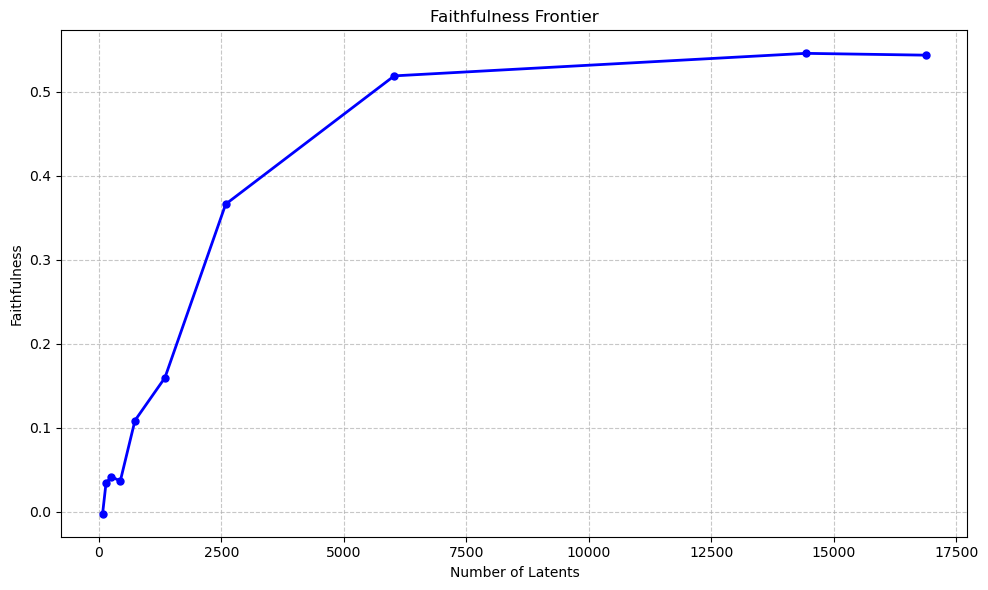

In [27]:

def plot_faithfulness_frontier(faithfulness_frontier):
    # Assuming faithfulness_frontier is your list of tuples
    # Example: faithfulness_frontier = [(10, 0.8), (20, 0.85), (30, 0.89), ...]

    # Unzip the tuples into separate lists for x and y coordinates
    num_latents, faithfulness = zip(*faithfulness_frontier)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(num_latents, faithfulness, 'b.-', linewidth=2, markersize=10)

    # Add labels and title
    plt.xlabel('Number of Latents')
    plt.ylabel('Faithfulness')
    plt.title('Faithfulness Frontier')

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Optionally, you can customize the axis ranges if needed
    # plt.xlim([min(num_latents), max(num_latents)])
    # plt.ylim([min(faithfulness), max(faithfulness)])

    # Display the plot
    plt.tight_layout()
    plt.show()
plot_faithfulness_frontier(ig_faithfulness_frontier)

In [28]:
avg_model_diff

6.643113613128662

# Circuit Comparisons

# circuit loading 

In [29]:
# task = "sva/rc"
# task = "codereason/index/len6_digit1"
task = "ioi/baba21"

In [30]:
thresholds = []
# modify_fn=lambda x: x
# thresholds = []
modify_fn=lambda x: x**2
start_threshold = 0.0001
end_threshold = 0.07
n_runs = 10
delta = (end_threshold - start_threshold) / n_runs
def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold
    
mf = lambda x: linear_map(modify_fn(x))
for i in range(n_runs):
    thresholds.append(
        mf(start_threshold + i*delta)
        )
nnodes = []
faithfulness = []
for i in thresholds[:6]:
    sparsity_multiplier = i
    bdir = f"masks/ioi/baba21/logit_diff_{str(sparsity_multiplier)}_run/{str(sparsity_multiplier)}_run.json"
    # load the dict 
    with open(bdir, 'r') as file:
        mask_dict = json.load(file)
    nnodes.append(mask_dict['total_density'])
    faithfulness.append(mask_dict['faithfulness'])
faithfulness

[1.0119456863665375,
 0.9484442726595069,
 0.8772018182497316,
 0.44343447171530326,
 0.2860409544674279,
 0.2538584051825639]

In [27]:

# Initialize variables
num_runs = 10
start = 0.05
end = 1
step = (end-start)/num_runs
nnodes = []
faithfulness = []
for i in range(num_runs):
    sparsity_multiplier = start + i*step
    bdir = f"masks/sva/rc/logit_diff_{str(sparsity_multiplier)}_run/{str(sparsity_multiplier)}_run.json"
    # load the dict 
    with open(bdir, 'r') as file:
        mask_dict = json.load(file)
    nnodes.append(mask_dict['total_density'])
    faithfulness.append(mask_dict['faithfulness'])

num_runs = 5
start_threshold = 1
end_threshold = 20 
modify_fn=lambda x: x**2

def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold
    
mf = lambda x: linear_map(modify_fn(x))
delta = (end_threshold - start_threshold) / num_runs

for i in range(num_runs):
    sparsity_multiplier = mf(start_threshold + i*delta)
    bdir = f"masks/sva/rc/logit_diff_{str(sparsity_multiplier)}_run/{str(sparsity_multiplier)}_run.json"
    # load the dict 
    with open(bdir, 'r') as file:
        mask_dict = json.load(file)
    nnodes.append(mask_dict['total_density'])
    faithfulness.append(mask_dict['faithfulness'])
faithfulness

[0.9661450982093811,
 0.9476482272148132,
 0.9827004075050354,
 0.9774459004402161,
 0.9635346531867981,
 0.9663353562355042,
 0.9663353562355042,
 0.9453681707382202,
 0.9453681707382202,
 0.9453681707382202,
 0.9399681091308594,
 0.8820058107376099,
 0.6360042095184326,
 0.5523359179496765,
 0.4533153474330902]

In [31]:
normalized_faithfulness = [f*avg_logit_diff/avg_model_diff for f in faithfulness]
normalized_faithfulness

[0.559081324288297,
 0.5239979646299544,
 0.4846378227828367,
 0.24498936555758524,
 0.15803235072678917,
 0.14025208592052368]

In [33]:
ig_faithfulness

(0.5433049095011857,
 0.5454715995319711,
 0.5186645572205212,
 0.36596023046567666,
 0.15926397355540658,
 0.10838192065114614,
 0.03617643075079788,
 0.0415847890686646,
 0.03382678235386713,
 -0.0025687467322534443)

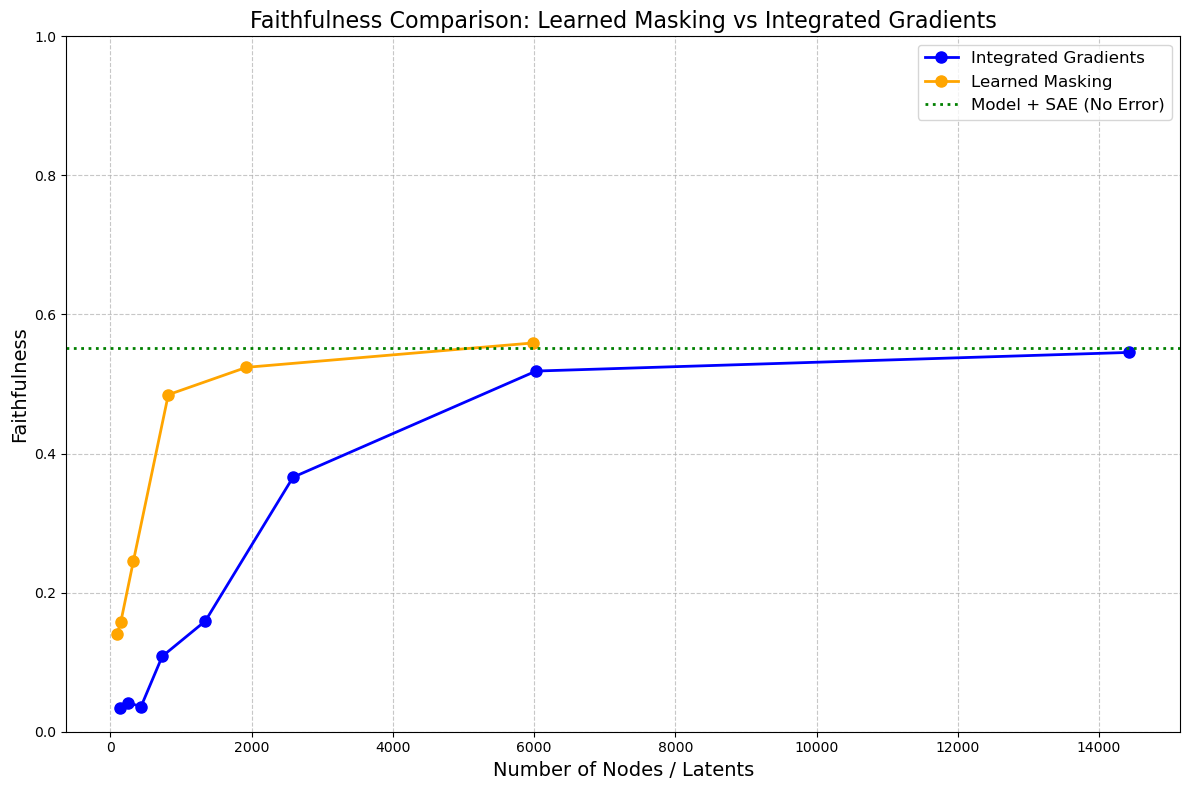

In [37]:
num_latents, ig_faithfulness = zip(*ig_faithfulness_frontier)

# Create the combined plot
plt.figure(figsize=(12, 8))

# Plot "Integrated Gradients"
plt.plot(num_latents[1:-1], ig_faithfulness[1:-1], marker='o',linestyle='-', linewidth=2, markersize=8,  label='Integrated Gradients', color='blue')

# Plot "Masking"
plt.plot(nnodes, normalized_faithfulness, marker='o', linestyle='-', linewidth=2, markersize=8, label='Learned Masking', color='orange')

plt.axhline(y=avg_logit_diff/avg_model_diff, color='green', linestyle='dotted', linewidth=2, label='Model + SAE (No Error)')

# Add labels, legend, and title
plt.xlabel('Number of Nodes / Latents', fontsize=14)
plt.ylabel('Faithfulness', fontsize=14)
plt.title('Faithfulness Comparison: Learned Masking vs Integrated Gradients', fontsize=16)
plt.legend(fontsize=12)
plt.ylim(0, 1)
# Add grid for better readability
plt.grid(visible=True, linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [64]:
ig_masks = []
def load_igmask(file_path):
    """Load an IGMask instance from a file."""
    state_dict = torch.load(file_path)

    # Ensure the loaded state contains the necessary components
    if 'ig_scores' not in state_dict:
        raise ValueError("The saved file does not contain the necessary components for IGMask.")

    # Recreate the IGMask instance
    igmask = IGMask(ig_scores=state_dict['ig_scores'])
    return igmask

for i in range(4):
    saes[i].igmask = load_igmask(f"masks/codereason/{task}/igmask/igmask_{saes[i].cfg.hook_layer}.pt")

/tmp/ipykernel_1853213/1811057840.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(file_path)


## Faithfulness 

In [ ]:
thresholds = []
modify_fn=lambda x: x**2
start_threshold = 0.01
end_threshold = 0.2
n_runs = 5
delta = (end_threshold - start_threshold) / n_runs
def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold
    
mf = lambda x: linear_map(modify_fn(x))
for i in range(n_runs):
    thresholds.append(
        mf(start_threshold + i*delta)
        )
thresholds


In [ ]:
import matplotlib.pyplot as plt
import json
thresholds = []
modify_fn=lambda x: x**2
# thresholds = []
# modify_fn=lambda x: x**2
start_threshold = 0.01
end_threshold = 0.2
n_runs = 5
delta = (end_threshold - start_threshold) / n_runs
def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold
    
mf = lambda x: linear_map(modify_fn(x))
for i in range(n_runs):
    thresholds.append(
        mf(start_threshold + i*delta)
        )
thresholds
nnodes = []
faithfulness = []
for i in thresholds:
    sparsity_multiplier = i
    bdir = f"masks/codereason/key/len5_digit1/logit_diff_{str(sparsity_multiplier)}_run/{str(sparsity_multiplier)}_run.json"
    # load the dict 
    with open(bdir, 'r') as file:
        mask_dict = json.load(file)
    nnodes.append(mask_dict['total_density'])
    faithfulness.append(mask_dict['faithfulness'])


# Unzip the tuples into separate lists for Integrated Gradients plot
num_latents, ig_faithfulness = zip(*ig_faithfulness_frontier)

# Create the combined plot
plt.figure(figsize=(12, 8))

# Plot "Integrated Gradients"
plt.plot(num_latents, ig_faithfulness, marker='o',linestyle='-', linewidth=2, markersize=8,  label='Integrated Gradients', color='blue')

# Plot "Masking"
plt.plot(nnodes, faithfulness, marker='o', linestyle='-', linewidth=2, markersize=8, label='Masking', color='orange')

# Add labels, legend, and title
plt.xlabel('Number of Nodes / Latents', fontsize=14)
plt.ylabel('Faithfulness', fontsize=14)
plt.title('Faithfulness Comparison: Masking vs Integrated Gradients', fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(visible=True, linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


## Completeness

In [ ]:
for sae in saes:
    sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length, distinct_l1=1.0).to(device)

def eval_logit_diff(batch, clean_labels, corr_labels, ratio_trained=10):
    for sae in saes:
        sae.mask.ratio_trained = ratio_trained
    logits = model.run_with_hooks(
        batch, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(batch, use_mask=True, mean_mask=True, binarize_mask=True)
        )
    return logit_diff_fn(logits, clean_labels, corr_labels)

model_logit_diff = 0 
with torch.no_grad():
    for i in range(10):
        batch_model_logit_diff = eval_logit_diff(clean_tokens[-i], clean_label_tokens[-i], corr_label_tokens[-i]).item()
        model_logit_diff += batch_model_logit_diff
    model_logit_diff = (model_logit_diff / 10)
    cleanup_cuda()
print("Logit Diff:", model_logit_diff)

In [ ]:
# Load masks before inference or further training
sparsity_multiplier = 0.04474285714285713
path = "masks/codereason/key/len5_digit1"
for idx, sae in enumerate(saes):
    mask_path = f"{path}/logit_diff_{str(sparsity_multiplier)}_run/sae_mask_{idx}.pt"
    state_dict = torch.load(mask_path)
    sae.mask.load_state_dict(state_dict)
    print(f"Loaded mask for SAE {idx} from {mask_path}")

circuit_logit_diff = 0
with torch.no_grad():
    for i in range(10):
        batch_circuit_logit_diff = eval_logit_diff(clean_tokens[-i], clean_label_tokens[-i], corr_label_tokens[-i]).item()
        circuit_logit_diff += batch_circuit_logit_diff
        cleanup_cuda()
    circuit_logit_diff = (circuit_logit_diff / 10)
print("Logit Diff:", circuit_logit_diff)

In [ ]:
sparsity_multiplier = 0.04474285714285713
path = "masks/codereason/key/len5_digit1"
bdir = f"{path}/logit_diff_{str(sparsity_multiplier)}_run/{str(sparsity_multiplier)}_run.json"
with open(bdir, 'r') as file:
    mask_dict = json.load(file)
mask_dict

In [29]:
import torch

# Number of elements to remove from the last dimension
num_remove = 5

# Number of batches to process
num_batches = 3  # Adjust this as needed
batch_size = 16  # Batch size for processing

# Remove random subsets of the mask along the [-1] dimension
def get_indices_to_remove(mask, num_remove):
    active_indices = (mask > 0).nonzero(as_tuple=True)[-1]  # Get indices of active elements in the last dimension
    if len(active_indices) < num_remove:
        raise ValueError("Not enough active elements to remove.")
    indices_to_remove = active_indices[torch.randperm(len(active_indices))[:num_remove]].to(mask.device)  # Move to the same device
    return indices_to_remove

def apply_subset_removal(mask, indices_to_remove):
    indices_to_remove = indices_to_remove.to(mask.device)  # Ensure indices are on the same device
    modified_mask = mask.clone()
    modified_mask.index_fill_(-1, indices_to_remove, -1.9455)  # Set selected elements to 0
    return modified_mask

## sfc like completeness

### mask

In [30]:
def eval_logit_diff(batch, clean_labels, corr_labels, ratio_trained=10):
    for sae in saes:
        sae.mask.ratio_trained = ratio_trained
    logits = model.run_with_hooks(
        batch, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(batch, use_mask=True, mean_mask=True, binarize_mask=True)
        )
    return logit_diff_fn(logits, clean_labels, corr_labels)

In [35]:
# Initialize variables
num_runs = 10
start = 0.05
end = 1
step = (end-start)/num_runs
mask_paths = []
for i in range(num_runs):
    sparsity_multiplier = start + i*step
    bdir = f"masks/sva/rc/logit_diff_{str(sparsity_multiplier)}_run/"
    mask_paths.append(bdir)

num_runs = 5
start_threshold = 1
end_threshold = 20 
modify_fn=lambda x: x**2
def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold
   
mf = lambda x: linear_map(modify_fn(x))
delta = (end_threshold - start_threshold) / num_runs
for i in range(num_runs):
    sparsity_multiplier = mf(start_threshold + i*delta)
    bdir = f"masks/sva/rc/logit_diff_{str(sparsity_multiplier)}_run/"
    mask_paths.append(bdir)

In [31]:
thresholds = []
mask_paths = []
modify_fn=lambda x: x**2
start_threshold = 0.01
end_threshold = 0.2
n_runs = 5
delta = (end_threshold - start_threshold) / n_runs
def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold
    
mf = lambda x: linear_map(modify_fn(x))
for i in range(n_runs):
    sparsity_multiplier = mf(start_threshold + i*delta)
    bdir = f"masks/codereason/key/len5_digit1/logit_diff_{str(sparsity_multiplier)}_run/"
    mask_paths.append(bdir)

mask_paths

['masks/codereason/key/len5_digit1/logit_diff_0.01_run/',
 'masks/codereason/key/len5_digit1/logit_diff_0.020495238095238094_run/',
 'masks/codereason/key/len5_digit1/logit_diff_0.04474285714285713_run/',
 'masks/codereason/key/len5_digit1/logit_diff_0.08274285714285712_run/',
 'masks/codereason/key/len5_digit1/logit_diff_0.13449523809523808_run/']

In [36]:
mask_paths

['masks/sva/rc/logit_diff_0.05_run/',
 'masks/sva/rc/logit_diff_0.14500000000000002_run/',
 'masks/sva/rc/logit_diff_0.24_run/',
 'masks/sva/rc/logit_diff_0.335_run/',
 'masks/sva/rc/logit_diff_0.43_run/',
 'masks/sva/rc/logit_diff_0.525_run/',
 'masks/sva/rc/logit_diff_0.6200000000000001_run/',
 'masks/sva/rc/logit_diff_0.7150000000000001_run/',
 'masks/sva/rc/logit_diff_0.81_run/',
 'masks/sva/rc/logit_diff_0.905_run/',
 'masks/sva/rc/logit_diff_1.0_run/',
 'masks/sva/rc/logit_diff_2.0495238095238095_run/',
 'masks/sva/rc/logit_diff_4.474285714285713_run/',
 'masks/sva/rc/logit_diff_8.274285714285714_run/',
 'masks/sva/rc/logit_diff_13.44952380952381_run/']

In [32]:
batch_idx = -1
nnodes = []
completeness = []
for mask_path in mask_paths: 
    mask_dict = {}
    indices_rem_list_full = []
    total_density = 0
    for ind, sae in enumerate(saes):
        bimask_path = f"{mask_path}/sae_mask_{ind}.pt"
        state_dict = torch.load(bimask_path)
        sae.mask.load_state_dict(state_dict)
        mask_dict[sae.cfg.hook_name] = torch.where(sae.mask.mask > 0)[1].tolist()
        total_density += (sae.mask.mask > 0).sum().item()
        indices_rem_list_full.append(torch.tensor(mask_dict[f"blocks.{layers[ind]}.hook_resid_post"]))
        sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length, distinct_l1=1.0).to(device)
        sae.mask.mask.data = apply_subset_removal(sae.mask.mask.data, indices_rem_list_full[ind]).to(device)
    logit_diff = eval_logit_diff(clean_tokens[-batch_idx], clean_label_tokens[-batch_idx], corr_label_tokens[-batch_idx]).item()
    nnodes.append(total_density)
    completeness.append(logit_diff/avg_model_diff)

/tmp/ipykernel_1999358/3758673996.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(bimask_path)


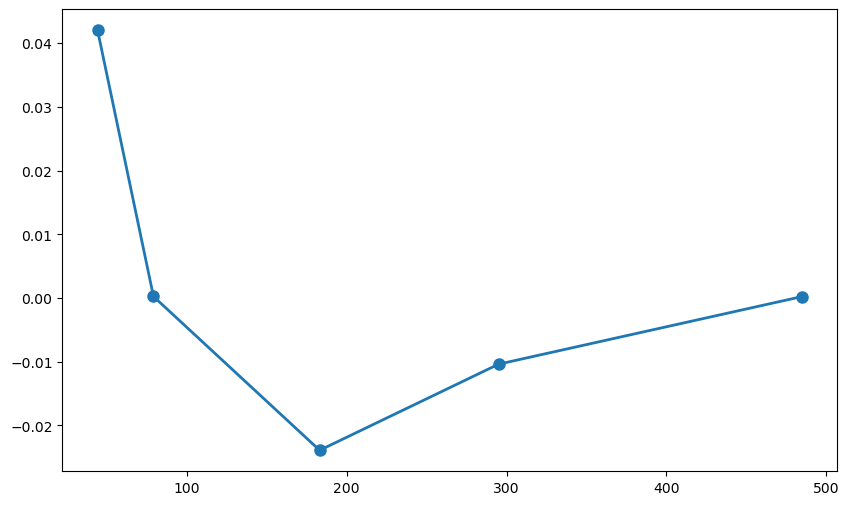

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(nnodes, completeness, marker='o', linestyle='-', linewidth=2, markersize=8)

### ig

In [38]:
thresholds = []
start_threshold, end_threshold = 0.005, 5 #0.005, 10 # 0.0005, 0.05
n_runs = 20
modify_fn=lambda x: x**2
delta = (end_threshold - start_threshold) / n_runs
def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold
    
mf = lambda x: linear_map(modify_fn(x))
for i in range(n_runs):
    thresholds.append(
        mf(start_threshold + i*delta)
        )
thresholds

[0.005,
 0.01796155094905095,
 0.05584820179820179,
 0.11865995254745254,
 0.20639680319680326,
 0.3190587537462537,
 0.4566458041958042,
 0.6191579545454546,
 0.8065952047952051,
 1.0189575549450547,
 1.256245004995005,
 1.518457554945055,
 1.8055952047952044,
 2.117657954545454,
 2.454645804195804,
 2.816558753746253,
 3.203396803196804,
 3.6151599525474527,
 4.051848201798201,
 4.513461550949052]

In [39]:
def produce_ig_binary_masks_complement(threshold=0.01):
    hook_points = []
    masks = []

    for sae in saes:
        hook_point = sae.cfg.hook_name
        mask = sae.igmask.get_binarized_mask(threshold=threshold)
        complement_mask = 1.0 - mask
        hook_points.append(hook_point)
        masks.append(complement_mask)
    
    return SAEMasks(
        hook_points=hook_points,
        masks=masks
    )

In [40]:
ig_completeness = []
ig_nnodes = []
for threshold in thresholds:
    complement_mask = produce_ig_binary_masks_complement(threshold=threshold)
    mask = produce_ig_binary_masks(threshold=threshold)
    num_latents = mask.get_num_latents()
    ig_nnodes.append(num_latents)
    # break
    ig_logits = model.run_with_hooks(
                    clean_tokens[-1], 
                    return_type="logits", 
                    fwd_hooks=build_hooks_list(clean_tokens[-1], circuit_mask=complement_mask, mean_mask=True)
                    )
    ld = logit_diff_fn(ig_logits, clean_label_tokens[-1], corr_label_tokens[-1])
    del ig_logits
    cleanup_cuda()
    print(ld)
    ig_completeness.append(ld.item()/avg_model_diff)

tensor(0.0421, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0646, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0980, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2832, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9941, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0604, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.3421, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1092, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1092, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1092, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1092, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1092, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0272, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0272, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0272, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0272, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0272, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0272, device='cuda:0'

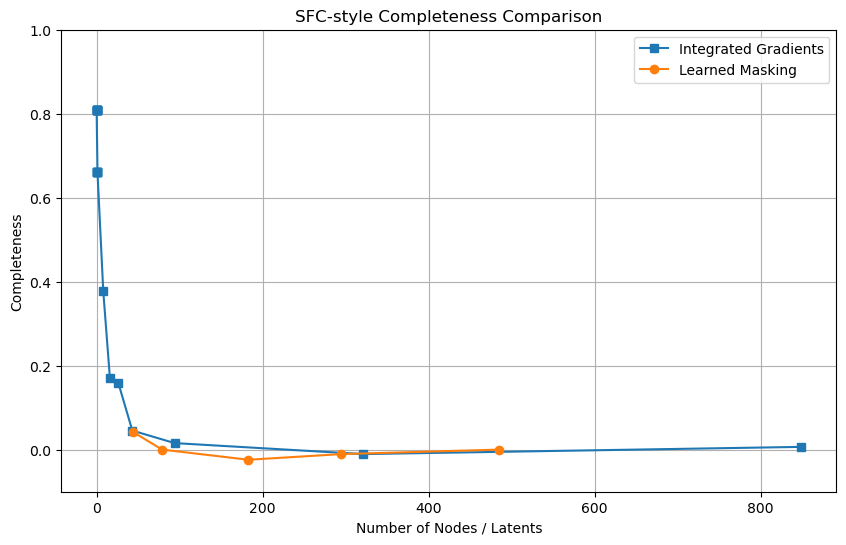

In [41]:
plt.figure(figsize=(10, 6))

plt.plot(ig_nnodes, ig_completeness, marker='s', label="Integrated Gradients")

# First plot: Label masking
plt.plot(nnodes, completeness, marker='o', label="Learned Masking")

# plt.axhline(y=avg_logit_diff/avg_model_diff, color='green', linestyle='dotted', linewidth=2, label='Model + SAE (No Error)')

# Adding labels and title
plt.xlabel("Number of Nodes / Latents")
plt.ylabel("Completeness")
plt.title("SFC-style Completeness Comparison")
plt.legend()
plt.grid(True)
plt.ylim(-0.1,1)
# Show the plot
plt.show()

## IOI style completeness

In [ ]:
random_k_results = []
for i in range(7):
    indices_rem_list = []
    for ind, sae in enumerate(saes):
        # Calculate random num_remove as approximately half the length of the mask
        mask_length = len(mask_dict[sae.cfg.hook_name])
        num_remove = random.randint(max(1, mask_length // 2 - int(mask_length*0.5)), mask_length // 2 + int(mask_length*0.5))
        indices_rem_list.append(get_indices_to_remove(sae.mask.mask.data, num_remove))
    random_k_results.append({"knockout_indices": indices_rem_list})
print(random_k_results)
        

In [ ]:
# Evaluate F(C \ K) and F(M \ K) for N batches
num_batches = 3
for rand_ind, k_results in enumerate(random_k_results):
    for case in ['circuit', 'model']:
        total_knock_logit_diff = 0.0
        for batch_idx in range(num_batches):
            sparsity_multiplier = 0.04474285714285713
            path = "masks/codereason/key/len5_digit1"
            with torch.no_grad():
                for ind, sae in enumerate(saes):
                    if case == 'circuit':
                        mask_path = f"{path}/logit_diff_{str(sparsity_multiplier)}_run/sae_mask_{ind}.pt"
                        state_dict = torch.load(mask_path)
                        sae.mask.load_state_dict(state_dict)
                    else:
                        sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length, distinct_l1=1.0).to(device)
                    sae.mask.mask.data = apply_subset_removal(sae.mask.mask.data, k_results['knockout_indices'][ind]).to(device)
                logit_diff = eval_logit_diff(clean_tokens[-batch_idx], clean_label_tokens[-batch_idx], corr_label_tokens[-batch_idx]).item()
                total_knock_logit_diff += logit_diff
                cleanup_cuda()
        # Average logit difference for the case
        avg_knock_logit_diff = total_knock_logit_diff / num_batches
        if case == 'circuit':
            print(f"Random set {rand_ind}, F(C \ K): {avg_knock_logit_diff}")
            random_k_results[rand_ind]['F_C_K'] = avg_knock_logit_diff
        else:
            print(f"Random set {rand_ind}, F(M \ K): {avg_knock_logit_diff}")
            random_k_results[rand_ind]['F_M_K'] = avg_knock_logit_diff

In [ ]:
indices_rem_list_full = []
for ind, sae in enumerate(saes):
    # Get indices to remove based on the original mask
    indices_rem_list_full.append(torch.tensor(mask_dict[f"blocks.{layers[ind]}.hook_resid_post"]))
indices_rem_list_full

In [ ]:
for case in ['circuit', 'model']:
    total_knock_logit_diff = 0.0
    for batch_idx in range(num_batches):
        sparsity_multiplier = 0.04474285714285713
        path = "masks/codereason/key/len5_digit1"
        with torch.no_grad():
            for ind, sae in enumerate(saes):
                if case == 'circuit':
                    mask_path = f"{path}/logit_diff_{str(sparsity_multiplier)}_run/sae_mask_{ind}.pt"
                    state_dict = torch.load(mask_path)
                    sae.mask.load_state_dict(state_dict)
                else:
                    sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length, distinct_l1=1.0).to(device)
                sae.mask.mask.data = apply_subset_removal(sae.mask.mask.data, indices_rem_list_full[ind]).to(device)
            logit_diff = eval_logit_diff(clean_tokens[-batch_idx], clean_label_tokens[-batch_idx], corr_label_tokens[-batch_idx]).item()
            total_knock_logit_diff += logit_diff
            cleanup_cuda()
    # Average logit difference for the case
    avg_knock_logit_diff = total_knock_logit_diff / num_batches
    if case == 'circuit':
        print(f"full_circ_knock_circ F(C \ K): {avg_knock_logit_diff}")
        full_circ_knock_circ = avg_knock_logit_diff
    else:
        print(f" full_circ_knock_model F(M \ K): {avg_knock_logit_diff}")
        full_circ_knock_model = avg_knock_logit_diff

In [ ]:
labels = ['Null Set']
for i in range(7):
    labels.append(f"Random Set {i}")
labels.append('Full Circuit Removal')

xy = [(circuit_logit_diff, model_logit_diff)]
for rand_ind, k_results in enumerate(random_k_results):
    xy.append((k_results['F_C_K'], k_results['F_M_K']))
xy.append((full_circ_knock_circ, full_circ_knock_model))

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
# Extract x and y values
# Separate the data into two groups
# Separate the data into two groups
null_set_xy = xy[0]
random_sets_xy = xy[1:-1]
full_circ_rem = xy[-1]

# Extract x and y values for linear regression
all_x = [point[0] for point in xy[:-1]]
all_y = [point[1] for point in xy[:-1]]

# Fit a linear regression model
regressor = LinearRegression()
all_x_reshaped = np.array(all_x).reshape(-1, 1)  # Reshape for sklearn
regressor.fit(all_x_reshaped, all_y)

# Generate points for the fitted line
fitted_x = np.linspace(min(all_x), max(all_x), 100)
fitted_y = regressor.predict(fitted_x.reshape(-1, 1))

# Extract x and y values for each group
null_set_x, null_set_y = null_set_xy
random_x = [point[0] for point in random_sets_xy]
random_y = [point[1] for point in random_sets_xy]
full_circ_x, full_circ_y = full_circ_rem
# Plot
plt.figure(figsize=(10, 7))

# Null set
plt.scatter(null_set_x, null_set_y, color='red', label='Null Set', s=100)

# Random sets
plt.scatter(random_x, random_y, color='blue', label='Random Sets', s=100)

# Full circuit removal
plt.scatter(full_circ_x, full_circ_y, color='green', label='Full Circuit Removal', s=100)

# Add reference line y = x
x_line = [min([null_set_x] + random_x + [null_set_y] + random_y), max([null_set_x] + random_x + [null_set_y] + random_y)]
plt.plot(x_line, x_line, linestyle="--", color="gray", label="y = x")

# Add fitted regression line
plt.plot(fitted_x, fitted_y, linestyle="--", color="green", label="Fitted Line")

# Customize plot
plt.title("Circuit Completeness Tests with Fitted Line", fontsize=14)
plt.xlabel("F(C \\ K)", fontsize=12)
plt.ylabel("F(M \\ K)", fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)

# Show plot
plt.show()

In [18]:
clean_data[0]

'>>> data = [4, 7, 5, 6, 8, 1]\n>>> data[4]\n'

In [19]:
thresholds

[0.01,
 0.020495238095238094,
 0.04474285714285713,
 0.08274285714285712,
 0.13449523809523808]

In [22]:
sparsity_multiplier = thresholds[2]
bdir = f"masks/codereason/index/len6_digit1/logit_diff_{str(sparsity_multiplier)}_run/{str(sparsity_multiplier)}_run.json"
sae_masks = []
example_length = 29
for i in range(4):
    sae_mask = SparseMask(saes[i].cfg.d_sae, 1.0, seq_len=example_length).to(device)
    sae_mask.load_state_dict(torch.load(f"masks/codereason/index/len6_digit1/logit_diff_{str(sparsity_multiplier)}_run/sae_mask_{i}.pt"))
    sae_masks.append(sae_mask)

/tmp/ipykernel_2711763/1048240858.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sae_mask.load_state_dict(torch.load(f"masks/codereason/index/len6_digit1/logit_diff_{st

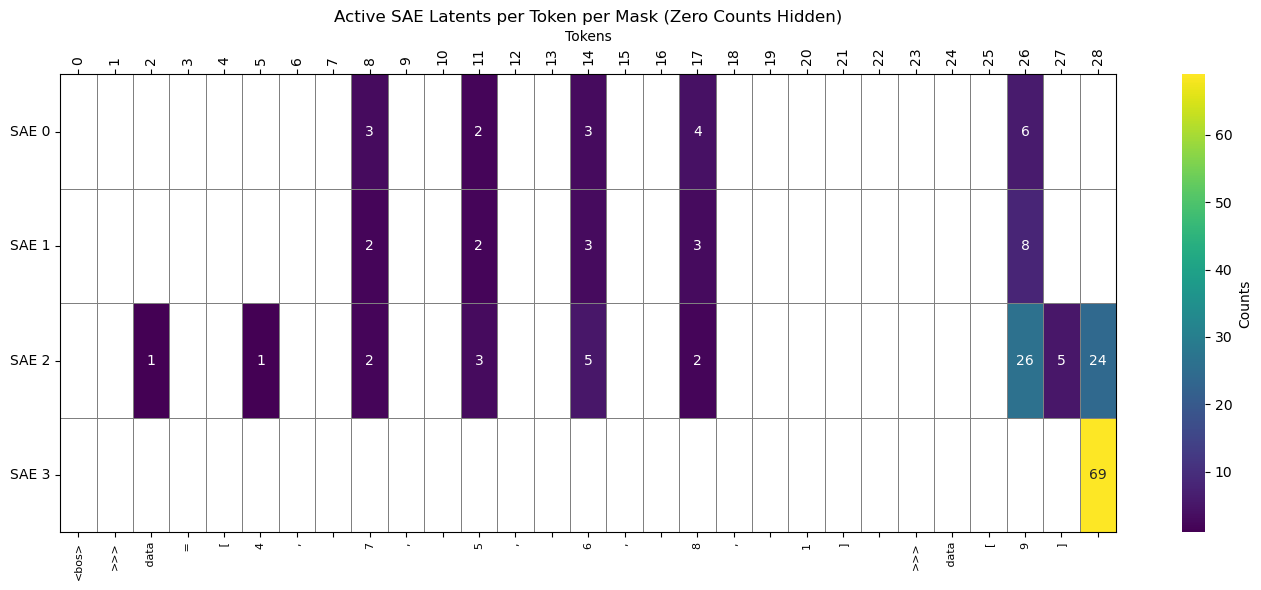

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

# Assuming 'saes', 'model', and 'simple_dataset' are defined
tokens = model.to_str_tokens(clean_data[1])
num_masks = 4 # Number of masks you have
counts_per_mask = []
for mask_index in range(num_masks):
    testmask = sae_masks[mask_index].mask.data.clone()
    binarized = (testmask > 0.0).float()
    counts = []
    for i in range(len(tokens)):
        counts.append(torch.count_nonzero(binarized[i]).item())
    counts_per_mask.append(counts)

# Convert counts to a NumPy array
data = np.array(counts_per_mask) # Shape: (num_masks, num_tokens)

# Create a mask for zero values
zero_mask = data == 0

# Define a colormap
cmap = sns.color_palette("viridis", as_cmap=True)

# Plot the heatmap with the mask
plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    data,
    annot=True,
    fmt='d',
    cmap=cmap,
    mask=zero_mask,
    cbar_kws={'label': 'Counts'},
    linewidths=0.5,
    linecolor='gray'
)

# Set x-axis labels to tokens
ax.set_xticks(np.arange(len(tokens)) + 0.5)
ax.set_xticklabels(tokens, rotation=90, fontsize=8)

# Add numeric indices above the chart
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(np.arange(len(tokens)) + 0.5)
ax2.set_xticklabels(np.arange(len(tokens)), rotation=90)  # Rotate indices 90 degrees
ax2.set_xlabel('Token Indices')

# Set y-axis labels to masks
ax.set_yticks(np.arange(num_masks) + 0.5)
ax.set_yticklabels([f'SAE {i}' for i in range(num_masks)], rotation=0)

plt.xlabel('Tokens')
plt.ylabel('SAE Number Active Latents')
plt.title('Active SAE Latents per Token per Mask (Zero Counts Hidden)')
plt.tight_layout()
plt.show()


In [27]:
bin_masks = []
for mask_index in range(num_masks):
    testmask = sae_masks[mask_index].mask.data.clone()
    binarized = (testmask > 0.0).float()
    bin_masks.append(binarized)

In [32]:
torch.nonzero(bin_masks[2][-2])

tensor([[ 1408],
        [ 3076],
        [ 4351],
        [12314],
        [15881]], device='cuda:0')

In [41]:
from transformer_lens.utils import test_prompt

prompt = """>>> age = {19: "Isabella", 11: "Emma", 17: "Tom", 18: "Ethan", 12: "Ava"}
>>> age["Ethan"]
"""
test_prompt(prompt, "Traceback", model, prepend_space_to_answer=False)

Tokenized prompt: ['<bos>', '>>>', ' age', ' =', ' {', '1', '9', ':', ' "', 'Isabella', '",', ' ', '1', '1', ':', ' "', 'Emma', '",', ' ', '1', '7', ':', ' "', 'Tom', '",', ' ', '1', '8', ':', ' "', 'Ethan', '",', ' ', '1', '2', ':', ' "', 'Ava', '"}', '\n', '>>>', ' age', '["', 'Ethan', '"]', '\n']
Tokenized answer: ['Traceback']


Performance on answer token:
Rank: 3        Logit: 25.19 Prob:  7.80% Token: |Traceback|

Top 0th token. Logit: 27.33 Prob: 66.12% Token: |1|
Top 1th token. Logit: 25.47 Prob: 10.29% Token: |'|
Top 2th token. Logit: 25.33 Prob:  8.96% Token: |>>>|
Top 3th token. Logit: 25.19 Prob:  7.80% Token: |Traceback|
Top 4th token. Logit: 23.18 Prob:  1.04% Token: |"|
Top 5th token. Logit: 22.94 Prob:  0.82% Token: |Syntax|
Top 6th token. Logit: 22.82 Prob:  0.73% Token: |2|
Top 7th token. Logit: 22.53 Prob:  0.55% Token: |None|
Top 8th token. Logit: 21.86 Prob:  0.28% Token: | |
Top 9th token. Logit: 21.81 Prob:  0.27% Token: |age|


Ranks of the answer tokens: [('Traceback', 3)]